<a href="https://colab.research.google.com/github/aryankargwal/Handwritten-Letter-Recognition/blob/master/Handwritten_Letter_Recognition_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Letter Recognition 
In the following code I have tried to recognize handwritten letters using a modified version of the LeNet-5 architecture on the MNIST dataset using PyTorch and have managed to get 99.20% accuracy on the validation set.

## Pre-Processing

### Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
! kaggle competitions download -c digit-recognizer

In [ ]:
!unzip \*.zip  && rm *.zip

In [6]:
df_train = pd.read_csv("/content/train.csv") #../input/digit-recognizer/train.csv
df_test = pd.read_csv("/content/test.csv")

In [7]:
print("Train File", df_train.shape)
print("Test File", df_test.shape)

Train File (42000, 785)
Test File (28000, 784)


### Data Exploration

In [8]:
display("Train File", df_train.describe())
display("Test File", df_test.describe())

'Train File'

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

'Test File'

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001357,0.012500,0.016786,0.031714,0.056000,0.100464,0.166929,...,3.272536,2.371464,1.454357,0.846286,0.509750,0.254750,0.062107,0.015250,0.000786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005429,0.024179,0.036250,0.083143,0.134107,0.201071,0.325000,0.366714,0.468143,0.589429,0.656964,0.569714,0.464214,0.323679,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227093,1.566275,1.513515,2.674449,3.216234,4.549478,5.470524,...,25.211706,21.240003,16.643468,12.637953,9.963879,7.031504,3.040514,1.265562,0.131475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640468,2.234963,2.493982,3.777711,4.946940,6.262819,7.714814,8.243535,8.974038,10.488695,11.209508,10.204173,9.402197,7.878854,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

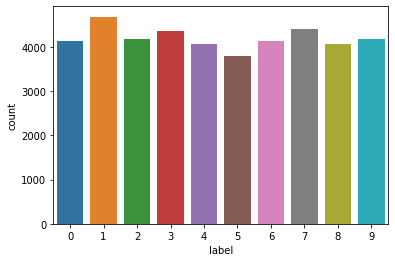

In [9]:
sns.countplot(df_train['label'])

### Train-Test split

In [10]:
y = df_train['label'].values
X = df_train.drop(['label'],1).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [11]:
print(y_test.shape)

(6300,)


## Training

### Imports

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torch.optim as optim

### Separate into labels and training images and reshape the images

In [13]:
train_labels = df_train['label'].values
train_images = (df_train.iloc[:,1:].values).astype('float32')
test_images = (df_test.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [14]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

### Convert images to tensors

In [15]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

### Load images into the data generator

In [16]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

### Defining Model

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [18]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### Define the optimizer and loss functions

In [19]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

### Training the model

In [20]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
            
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = conv_model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [21]:
num_epochs = 10

for n in range(num_epochs):
    train_model(n)
    evaluate(val_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Epoch: 0 [1600/33600 (5%)]	Loss: 0.914788
Train Epoch: 0 [3200/33600 (10%)]	Loss: 0.335747
Train Epoch: 0 [4800/33600 (14%)]	Loss: 0.243646
Train Epoch: 0 [6400/33600 (19%)]	Loss: 0.275152
Train Epoch: 0 [8000/33600 (24%)]	Loss: 0.575230
Train Epoch: 0 [9600/33600 (29%)]	Loss: 0.294781
Train Epoch: 0 [11200/33600 (33%)]	Loss: 0.441929
Train Epoch: 0 [12800/33600 (38%)]	Loss: 0.240061
Train Epoch: 0 [14400/33600 (43%)]	Loss: 0.174218
Train Epoch: 0 [16000/33600 (48%)]	Loss: 0.394327
Train Epoch: 0 [17600/33600 (52%)]	Loss: 0.256539
Train Epoch: 0 [19200/33600 (57%)]	Loss: 0.140435
Train Epoch: 0 [20800/33600 (62%)]	Loss: 0.988514
Train Epoch: 0 [22400/33600 (67%)]	Loss: 0.154986
Train Epoch: 0 [24000/33600 (71%)]	Loss: 0.345560
Train Epoch: 0 [25600/33600 (76%)]	Loss: 0.043270
Train Epoch: 0 [27200/33600 (81%)]	Loss: 0.655127
Train Epoch: 0 [28800/33600 (86%)]	Loss: 0.331259
Train Epoch: 0 [30400/33600 (90%)]	Loss: 0.183614
Train Epoch: 0 [32000/33600 (95%)]	Loss: 0.497971
Train E

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 0.0642, Val Accuracy: 8234/8400 (98.024%)

Train Epoch: 1 [1600/33600 (5%)]	Loss: 0.468318
Train Epoch: 1 [3200/33600 (10%)]	Loss: 0.372624
Train Epoch: 1 [4800/33600 (14%)]	Loss: 0.024437
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.173822
Train Epoch: 1 [8000/33600 (24%)]	Loss: 1.362533
Train Epoch: 1 [9600/33600 (29%)]	Loss: 0.364603
Train Epoch: 1 [11200/33600 (33%)]	Loss: 0.049464
Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.645423
Train Epoch: 1 [14400/33600 (43%)]	Loss: 0.911551
Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.224738
Train Epoch: 1 [17600/33600 (52%)]	Loss: 1.072144
Train Epoch: 1 [19200/33600 (57%)]	Loss: 0.100497
Train Epoch: 1 [20800/33600 (62%)]	Loss: 0.235826
Train Epoch: 1 [22400/33600 (67%)]	Loss: 0.065826
Train Epoch: 1 [24000/33600 (71%)]	Loss: 0.134915
Train Epoch: 1 [25600/33600 (76%)]	Loss: 0.029356
Train Epoch: 1 [27200/33600 (81%)]	Loss: 0.364782
Train Epoch: 1 [28800/33600 (86%)]	Loss: 0.095822
Train Epoch: 1 [30400/33600 (90%)]	Loss: 0.31